# Training a CNN model on CIFAR10

### Install dependencies

In [1]:
%pip install matplotlib seaborn torch torchvision torchaudio numpy

Note: you may need to restart the kernel to use updated packages.


#### Prepare imports

In [2]:
import matplotlib.pyplot as plt # This is to load plotting functions
import seaborn as sns; sns.set() # This is to make the plots prettier
import torch # This is the ML library we will use
import torchvision # This is the supporting ML library for computer vision
from torchvision import datasets # This is to access the CIFAR10 dataset
from torch.utils.data import DataLoader # This is used to load the data efficiently
import torchvision.transforms as transforms # This is used to transform data when preparing the dataset
import numpy as np # This is used to handle arrays of data

#### Select the device from GPU and CPU

In [3]:
# If GPU is available, it is chosen for computations, and if not, CPU will be used
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

#### Download the CIFAR10 dataset and create tran and test data loaders

In [4]:
# This is used to normalize input images
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

train_set = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified
Files already downloaded and verified


#### Show example images from the dataset.

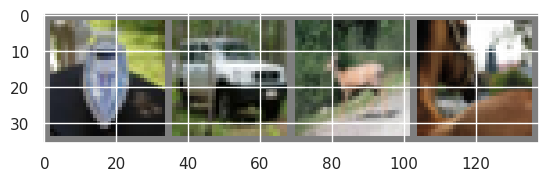

ship  car   deer  horse


In [5]:

def imshow(img):
    # Unnormalize
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

#### Create a simple CNN classifier model

In [6]:
class Cifar10Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.body = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=3,
                out_channels=6,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(
                in_channels=6,
                out_channels=16,
                kernel_size=5,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Flatten(),
            torch.nn.Linear(16 * 6 * 6, 120),
            torch.nn.ReLU(),
            torch.nn.Linear(120, 84),
            torch.nn.ReLU(),
            torch.nn.Linear(84, 10),
            torch.nn.ReLU(),
        )

    def forward(self, x):
        output = self.body(x)
        return output

In [7]:
model = Cifar10Classifier()
model.to(device)

Cifar10Classifier(
  (body): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=576, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
    (12): ReLU()
  )
)

#### Create a loss function and an optimizer.

In [8]:
learning_rate = 0.001

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Train the model.

In [9]:
def train(num_epochs, model, loss_func, optimizer):

    model.train()

    # Train the model
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        # For each batch in the training data
        for i, (images, labels) in enumerate(train_loader):

            images = images.to(device)
            labels = labels.to(device)

            # Compute output and loss
            output = model(images)
            loss = loss_func(output, labels)

            # Clear gradients for this training step
            optimizer.zero_grad()

            # Compute gradients
            loss.backward()
            # Apply gradients
            optimizer.step()

            if (i + 1) % 100 == 0:
                print(
                    "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(
                        epoch + 1, num_epochs, i + 1, total_step, loss.item()
                    )
                )

    print("Done.")


train(2, model, loss_func, optimizer)

/home/io/miniconda3/envs/diip/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/io/miniconda3/envs/diip/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/2], Step [100/12500], Loss: 2.2639
Epoch [1/2], Step [200/12500], Loss: 2.3026
Epoch [1/2], Step [300/12500], Loss: 2.3751
Epoch [1/2], Step [400/12500], Loss: 2.5028
Epoch [1/2], Step [500/12500], Loss: 2.2883
Epoch [1/2], Step [600/12500], Loss: 2.3042
Epoch [1/2], Step [700/12500], Loss: 2.3026
Epoch [1/2], Step [800/12500], Loss: 2.2041
Epoch [1/2], Step [900/12500], Loss: 2.4255
Epoch [1/2], Step [1000/12500], Loss: 2.3026
Epoch [1/2], Step [1100/12500], Loss: 2.3053
Epoch [1/2], Step [1200/12500], Loss: 2.3026
Epoch [1/2], Step [1300/12500], Loss: 2.3026
Epoch [1/2], Step [1400/12500], Loss: 1.4607
Epoch [1/2], Step [1500/12500], Loss: 2.3026
Epoch [1/2], Step [1600/12500], Loss: 2.3026
Epoch [1/2], Step [1700/12500], Loss: 1.6503
Epoch [1/2], Step [1800/12500], Loss: 2.3026
Epoch [1/2], Step [1900/12500], Loss: 2.1428
Epoch [1/2], Step [2000/12500], Loss: 2.3026
Epoch [1/2], Step [2100/12500], Loss: 2.3313
Epoch [1/2], Step [2200/12500], Loss: 3.5168
Epoch [1/2], Step [

Now, test the trained model.

In [10]:
def test(model):
    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:

            images = images.to(device)
            labels = labels.to(device)

            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct += (pred_y == labels).sum().item()
            total += labels.size(0)
        
        accuracy = correct / float(total)
        print('Test Accuracy of the model: %.2f%%' % (accuracy * 100))
test(model)

Test Accuracy of the model: 15.80%


#### Now, let us train more and see how the result changes.

In [11]:
train(1, model, loss_func, optimizer)

Epoch [1/1], Step [100/12500], Loss: 1.7510
Epoch [1/1], Step [200/12500], Loss: 1.8582
Epoch [1/1], Step [300/12500], Loss: 1.3237
Epoch [1/1], Step [400/12500], Loss: 2.5294
Epoch [1/1], Step [500/12500], Loss: 2.1537
Epoch [1/1], Step [600/12500], Loss: 2.3026
Epoch [1/1], Step [700/12500], Loss: 2.3026
Epoch [1/1], Step [800/12500], Loss: 1.2785
Epoch [1/1], Step [900/12500], Loss: 1.7785
Epoch [1/1], Step [1000/12500], Loss: 2.3319
Epoch [1/1], Step [1100/12500], Loss: 2.3026
Epoch [1/1], Step [1200/12500], Loss: 1.9006
Epoch [1/1], Step [1300/12500], Loss: 2.3645
Epoch [1/1], Step [1400/12500], Loss: 2.2754
Epoch [1/1], Step [1500/12500], Loss: 2.3026
Epoch [1/1], Step [1600/12500], Loss: 1.7279
Epoch [1/1], Step [1700/12500], Loss: 2.3026
Epoch [1/1], Step [1800/12500], Loss: 2.3026
Epoch [1/1], Step [1900/12500], Loss: 1.9623
Epoch [1/1], Step [2000/12500], Loss: 1.9422
Epoch [1/1], Step [2100/12500], Loss: 1.7309
Epoch [1/1], Step [2200/12500], Loss: 2.3160
Epoch [1/1], Step [

In [12]:
test(model)

Test Accuracy of the model: 16.43%


## Pretrained ResNet18 model

#### Load the pretrained model from torchvision.

In [13]:
resnet18 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### ImageNet has different image size and the number of classes.

We can adapt this model by changing the first and the last layers to fit our needs.
Those layers are untrained, but the knowledge from all other layers is still relevant and helps the model to be trained faster.

The first convolutional layer of ResNet needs to receive as input an image with 3 channels, have 64 output channels, 3x3 filter, stride 1 and padding 1 with no bias.

The last fully-connected layer should receive as input a vector with the same number of features as before, but the number of output dimensions should be equal to the number of classes in CIFAR10.

<details>
<summary>Solution</summary>
    <code>
    resnet18.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)<br>
    num_features = resnet18.fc.in_features<br>
    resnet18.fc = torch.nn.Linear(num_features, num_classes)<br>
    </code>
</details>

In [14]:
num_classes = 10
resnet18.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
num_features = resnet18.fc.in_features
resnet18.fc = torch.nn.Linear(num_features, num_classes)
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### It is pretrained on ImageNet, so the starting accuracy on CIFAR10 should be bad, let us check it.

In [15]:
test(resnet18)

Test Accuracy of the model: 10.17%


#### Prepare the training objects.

In [16]:
learning_rate = 0.001

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=learning_rate)

#### Train and test

In [17]:
train(2, resnet18, loss_func, optimizer)

Epoch [1/2], Step [100/12500], Loss: 3.3114
Epoch [1/2], Step [200/12500], Loss: 1.9990
Epoch [1/2], Step [300/12500], Loss: 2.1024
Epoch [1/2], Step [400/12500], Loss: 1.6189
Epoch [1/2], Step [500/12500], Loss: 2.9877
Epoch [1/2], Step [600/12500], Loss: 2.5482
Epoch [1/2], Step [700/12500], Loss: 2.0533
Epoch [1/2], Step [800/12500], Loss: 2.1024
Epoch [1/2], Step [900/12500], Loss: 2.6723
Epoch [1/2], Step [1000/12500], Loss: 1.6668
Epoch [1/2], Step [1100/12500], Loss: 2.1073
Epoch [1/2], Step [1200/12500], Loss: 2.5352
Epoch [1/2], Step [1300/12500], Loss: 2.7733
Epoch [1/2], Step [1400/12500], Loss: 1.5921
Epoch [1/2], Step [1500/12500], Loss: 3.2069
Epoch [1/2], Step [1600/12500], Loss: 1.4908
Epoch [1/2], Step [1700/12500], Loss: 2.3276
Epoch [1/2], Step [1800/12500], Loss: 2.0843
Epoch [1/2], Step [1900/12500], Loss: 1.8644
Epoch [1/2], Step [2000/12500], Loss: 2.2740
Epoch [1/2], Step [2100/12500], Loss: 1.7453
Epoch [1/2], Step [2200/12500], Loss: 2.4063
Epoch [1/2], Step [

In [18]:
test(resnet18)

Test Accuracy of the model: 70.88%
